# Auxiiliary Notebook - Converting sediment thickness grids (total) from Merdith et al. (2021) to Muller et al. (2022) reference frames

In [10]:
import cartopy.crs as ccrs
import gplately
import matplotlib.pyplot as plt
import matplotlib.cm as cmp
import matplotlib.colors as mcolors
import os, glob
import copy
import numpy as np
from joblib import Parallel, delayed

import math
import ptt
import pygplates

In [18]:
# Also GMT needs to be available (on the command-line).

def read_grid(
        input,
        *grid_filenames):
    """
    Samples one or more grid files at the specified locations.
    
    'input' is a list of (longitude, latitude, [other_values ...]) tuples where latitude and longitude are in degrees.
    Should at least have 2-tuples (longitude, latitude) but 'grdtrack' allows extra columns.
    
    Returns a list of tuples of float values.
    For example, if input was (longitude, latitude) tuples and one grid file specified then output is (longitude, latitude, sample) tuples.
    If input was (longitude, latitude, value) tuples and two grid file specified then output is (longitude, latitude, value, sample_grid1, sample_grid2) tuples.
    """
    
    # Create a multiline string (one line per lon/lat/value1/etc row).
    location_data = ''.join(
            ' '.join(str(item) for item in row) + '\n' for row in input)

    # The command-line strings to execute GMT 'grdtrack'.
    grdtrack_command_line = ["gmt", "grdtrack",
        # Geographic input/output coordinates...
        "-fg",
        # Avoid anti-aliasing...
        #"-n+a+bg+t0.5"]
         "-nl+a+bg+t0.5"]
    # One or more grid filenames to sample.
    for grid_filename in grid_filenames:
        grdtrack_command_line.append("-G{0}".format(grid_filename))
    
    # Call the system command.
    stdout_data = ptt.utils.call_system_command(grdtrack_command_line, stdin=location_data, return_stdout=True)

    # Extract the sampled values.
    output_values = []
    for line in stdout_data.splitlines():
        # Each line returned by GMT grdtrack contains "longitude latitude grid1_value [grid2_value ...]".
        # Note that if GMT returns "NaN" then we'll return float('nan').
        output_value = tuple(float(value) for value in line.split())
        output_values.append(output_value)
    
    return output_values


def write_grid(
        input,
        grid_spacing_degrees,
        grid_filename):
    """
    Run 'gmt nearneighbor' on grid locations/values to output a grid file.
    
    'input' is a list of (longitude, latitude, value) tuples where latitude and longitude are in degrees.
    'grid_spacing_degrees' is spacing of output grid points in degrees.
    """
    
    # Create a multiline string (one line per lon/lat/value row).
    input_data = ''.join(
            ' '.join(str(item) for item in row) + '\n' for row in input)

    # The command-line strings to execute GMT 'nearneighbor'.
    nearneighbor_command_line = [
        "gmt",
        "nearneighbor",
        "-N4/1", # Divide search radius into 4 sectors but only require a value in 1 sector.
        "-S{0}d".format(0.9 * grid_spacing_degrees),
        "-I{0}".format(grid_spacing_degrees),
        # Use GMT gridline registration since our input point grid has data points on the grid lines.
        # Gridline registration is the default so we don't need to force pixel registration...
        # "-r", # Force pixel registration since data points are at centre of cells.
        "-Rd",
        "-fg",
        "-G{0}".format(grid_filename)]
    
    # Call the system command.
    ptt.utils.call_system_command(nearneighbor_command_line, stdin=input_data)


def generate_input_points_grid(grid_spacing_degrees):
    """
    Generate a global grid of points uniformly spaced in latitude and longitude.

    Returns a list of (longitude, latitude) tuples.
    """
    
    if grid_spacing_degrees == 0:
        raise ValueError('Grid spacing cannot be zero.')
    
    input_points = []
    
    # Data points start *on* dateline (-180).
    # If 180 is an integer multiple of grid spacing then final longitude also lands on dateline (+180).
    num_latitudes = int(math.floor(180.0 / grid_spacing_degrees)) + 1
    num_longitudes = int(math.floor(360.0 / grid_spacing_degrees)) + 1
    for lat_index in range(num_latitudes):
        lat = -90 + lat_index * grid_spacing_degrees
        
        for lon_index in range(num_longitudes):
            lon = -180 + lon_index * grid_spacing_degrees
            
            input_points.append((lon, lat))
    
    return input_points


def get_reference_frame_conversion_rotation(
        reconstruction_time,
        non_reference_plate,
        from_rotation_features_or_model,  # filename(s), or pyGPlates feature(s)/collection(s) or a RotationModel
        from_rotation_reference_plate,
        to_rotation_features_or_model,    # filename(s), or pyGPlates feature(s)/collection(s) or a RotationModel
        to_rotation_reference_plate):
    """
    Return the pygplates.FiniteRotation that rotates between the two reference frames.
    """
    from_rotation_model = pygplates.RotationModel(from_rotation_features_or_model)
    to_rotation_model = pygplates.RotationModel(to_rotation_features_or_model)

    #
    # Calculate the rotation from the input mantle grid to the output mantle grid.
    #
    # This is the rotation from G_from to G_to, where G_from is a reconstructed input grid position
    # (reconstructed from present day position G using the 'from' rotation model) and G_to is the
    # reconstructed position (again from present day position G) using the 'to' rotation model.
    #
    # R_from(0->t, P_from_ref->P): rotation from time 0 to 't' and from plate 'P_from_ref' to plate 'P'
    #                              using the 'from' rotation model.
    # R_to(0->t, P_to_ref->P): rotation from time 0 to 't' and from plate 'P_to_ref' to plate 'P'
    #                          using the 'to' rotation model.
    #
    # G_from(t, P) = R_from(0->t, P_from_ref->P) * G
    # G            = inverse[R_from(0->t, P_from_ref->P)] * G_from(t, P)
    # G_to(t, P)   = R_to(0->t, P_to_ref->P) * G
    #              = R_to(0->t, P_to_ref->P) * inverse[R_from(0->t, P_from_ref->P)] * G_from(t, P)
    #
    # See https://www.gplates.org/docs/pygplates/pygplates_foundations.html#composing-finite-rotations
    #     for more details on composing rotations.
    #
    from_rotation = from_rotation_model.get_rotation(
        reconstruction_time, non_reference_plate, anchor_plate_id=from_rotation_reference_plate)
    to_rotation = to_rotation_model.get_rotation(
        reconstruction_time, non_reference_plate, anchor_plate_id=to_rotation_reference_plate)
    
    return to_rotation * from_rotation.get_inverse()


def convert_mantle_grid_reference_frame(
        input_grid_filename,
        output_grid_filename,
        grid_spacing_degrees,
        reference_frame_conversion_rotation):
    """
    Rotate the input NetCDF grid by the reference frame conversion rotation and save as the output NetCDF grid.
    """
    # Generate a global latitude/longitude grid of points (with the requested grid spacing).
    input_positions = generate_input_points_grid(grid_spacing_degrees)

    # Read the input grid file and only include those that have non-NaN values.
    input_samples = [
        sample for sample in read_grid(input_positions, input_grid_filename) if not math.isnan(sample[2])]

    # Convert lon-lat points to pyGPlates points.
    input_points = pygplates.MultiPointOnSphere((lat, lon) for lon, lat, _ in input_samples)
    # Grid values.
    values = [value for _, _, value in input_samples]

    # Rotate grid points from 'from_plate' to 'to_plate' at 'time'.
    output_points = reference_frame_conversion_rotation * input_points

    # Assemble rotated points with grid values.
    output_samples = []
    for index, point in enumerate(output_points):
        lat, lon = point.to_lat_lon()
        value = values[index]
        output_samples.append((lon, lat, value))

    # Write output grid.
    write_grid(output_samples, grid_spacing_degrees, output_grid_filename)
    
    
def parallel_convert_mantle_grid_reference_frame(
    time, 
    from_rotation_files, 
    from_rotation_reference_plate,
    to_rotation_files,
    to_rotation_reference_plate, 
    non_reference_plate,
    grid_spacing_degrees, 
    input_grid_filename, 
    output_grid_filename
):

    # Get the pygplates.FiniteRotation that rotates between the two reference frames.
    reference_frame_conversion_rotation = get_reference_frame_conversion_rotation(
        time,
        non_reference_plate,
        from_rotation_files,
        from_rotation_reference_plate,
        to_rotation_files,
        to_rotation_reference_plate)

    # Rotate the input NetCDF grid by the above reference frame conversion rotation 
    # and save as the output NetCDF grid.
    convert_mantle_grid_reference_frame(
        input_grid_filename,
        output_grid_filename,
        grid_spacing_degrees,
        reference_frame_conversion_rotation)
    return


In [19]:
# Change this: directory to folder CO2_Review_Bundle
bundle_parent_directory = "/Volumes/VERBATIMHD/"

parent_directory = bundle_parent_directory+"CO2_review_Bundle/"

input_directory = parent_directory+ "CO2_review_inputs/"
output_directory = parent_directory+ "CO2_review_outputs/"

# --------------- Everything below here can be kept as-is ----------------
carbon_components = ["Sediment", "Serpentinite", "Crust", "Lithosphere"]
quantities = ['min', 'mean', 'max']

for component in carbon_components:
    for quantity in quantities:
        # Create output path for rotated grids
        output_grid_path = "/Volumes/VERBATIMHD/CO2_Review_Bundle/Muller2022/CO2_review_outputs/Notebook08/Muller2022_rotated_total_sediment_thickness_250-0/"
        os.makedirs(output_grid_path, exist_ok=True)

# output_figure_path = os.path.join(output_directory, "Notebook08/MaskedSediments/figures/")
# os.makedirs(output_figure_path, exist_ok=True)


### Define Merdith et al. (2021) and Muller et al. (2022) plate reconstruction model files:
#### Muller2022
An optimised mantle refernce frame

#### Merdith2021
A palaeomagnetic reference frame derived from Tetley (2018).

In [13]:
# Download some coastlines (this is a different plate model but only use the coastlines).
m21 = gplately.download.DataServer("Muller2022")
m21_rotation_model, m21_topology_features, m21_static_polygons = m21.get_plate_reconstruction_files()
m21_coastlines, m21_continents, m21_COBs = m21.get_topology_geometries()

# Download some coastlines (this is a different plate model but only use the coastlines).
m22 = gplately.download.DataServer("Merdith2021")
m22_rotation_model, m22_topology_features, m22_static_polygons = m22.get_plate_reconstruction_files()
m22_coastlines, m22_continents, m22_COBs = m22.get_topology_geometries()

Checking whether the requested files need to be updated...
Requested files are up-to-date!
No static polygons in Muller2022.
Checking whether the requested files need to be updated...
Requested files are up-to-date!
Checking whether the requested files need to be updated...
Requested files are up-to-date!
Checking whether the requested files need to be updated...
Requested files are up-to-date!
No continent-ocean boundaries in Merdith2021.


### Define necessary parameters

In [15]:
# For our Merdith et al. (2021) analysis we have grids at the following times.
min_time = 0
max_time = 1000
timestep_size = 1
reconstruction_times = np.arange(max_time, min_time-timestep_size, -timestep_size)


# Start with the Merdith et al. (2021) paleomagnetic reference frame (plate_id = 0)
from_rotation_files = m21_rotation_model.filenames
from_rotation_reference_plate = 0

# Rotate using the Muller et al. (2022) mantle reference frame (plate_id = 0)
to_rotation_files = [
    
    "./InputPlateModel/1000_0_rotfile_Merdith_et_al_optimised.rot"
]
to_rotation_reference_plate = 0


# Any plate that is not a reference plate. This is needed so that we can obtain a 
# rotation from each model relative to its reference plate.
non_reference_plate = 701

# Input and output grid sample spacing (in degrees).
grid_spacing_degrees = 0.5


# Input and output grids.
input_grid_filename = "/Volumes/VERBATIMHD/CO2_Review_Bundle/CO2_review_inputs/Notebook04/Merdith_etal_2021_total_sediment_thickness_250-0Ma/sed_thick_0.25d_{}.nc"
output_grid_filename = output_grid_path+"sed_thick_0.25d_{}.nc"


# Do the actual conversion of mantle grids

In [6]:
use_parallel = True

In [22]:
# For Serpentinite, rotate grids from 170-0Ma only.
reconstruction_times = np.arange(250, min_time-timestep_size, -timestep_size)
forward_reconstruction_times = np.arange(min_time, 170+timestep_size, timestep_size)
component = "Sediment"

if not use_parallel:

    for t, reconstruction_time in enumerate(sediment_reconstruction_times):

        parallel_convert_mantle_grid_reference_frame(
            reconstruction_time, 
          from_rotation_files, 
          from_rotation_reference_plate,
          to_rotation_files,
          to_rotation_reference_plate,
          non_reference_plate,
          grid_spacing_degrees, 
          input_grid_filename.format(component, quantity, component.lower(), reconstruction_time), 
          output_grid_filename.format(component, quantity, component.lower(), reconstruction_time),
        )

        # Use 0 --> 1000Ma array for the progress bar
        gplately.tools.update_progress(forward_reconstruction_times[t]/max_time)
        
else:      
    # Use LokyBackend to protect the netCDF routine
    converted_frames = Parallel(n_jobs=-2, backend='loky', verbose=1) \
    (delayed(parallel_convert_mantle_grid_reference_frame) \
     (reconstruction_time, 
      from_rotation_files, 
      from_rotation_reference_plate,
      to_rotation_files,
      to_rotation_reference_plate,
      non_reference_plate,
      grid_spacing_degrees, 
      input_grid_filename.format(reconstruction_time), 
      output_grid_filename.format(reconstruction_time),
     )
    for i, reconstruction_time in enumerate(reconstruction_times)
    )

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=-2)]: Done  32 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-2)]: Done 182 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-2)]: Done 251 out of 251 | elapsed:  2.1min finished


# Visualise an input mantle grid and converted output grid for a specific reconstruction time.

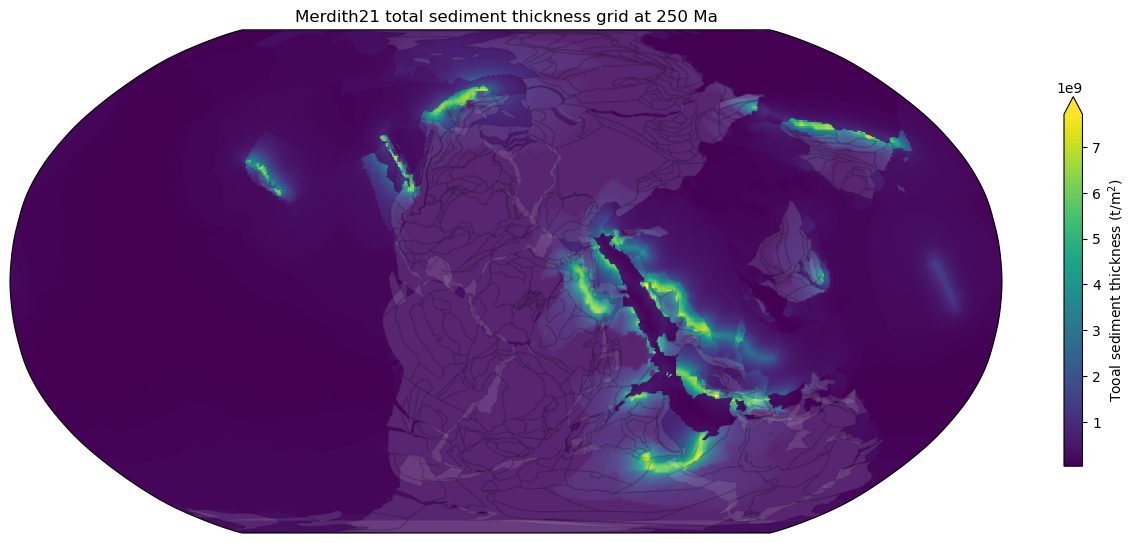

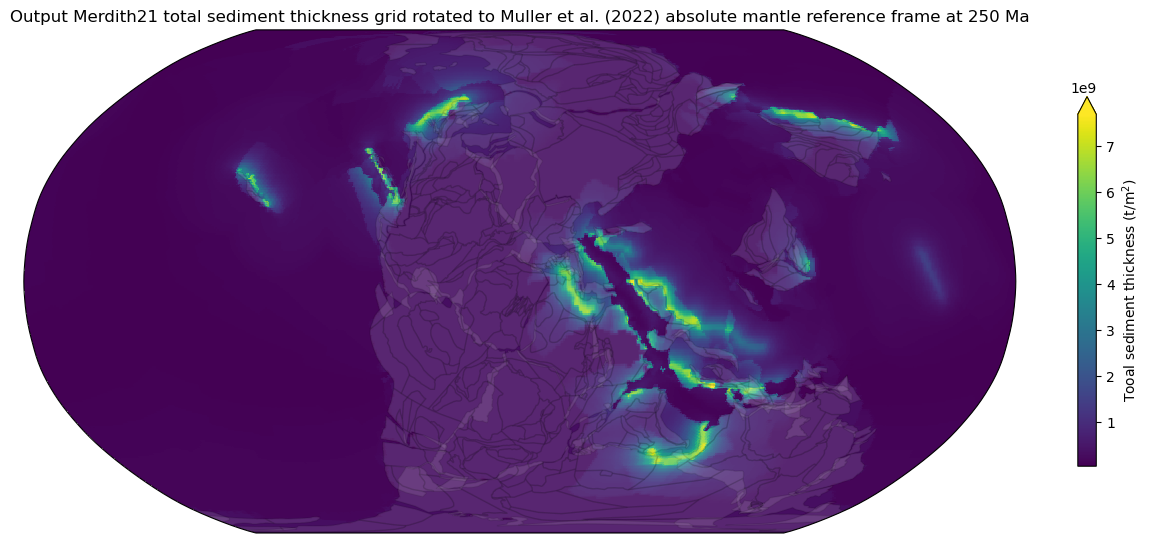

In [31]:
# Use gplately to visualise the grids.
#
# Just visualizing for a single reconstruction time here.
visualise_time = 250
component = "Sediment"

# Input and output grids.
input_grid_filename = "/Volumes/VERBATIMHD/CO2_Review_Bundle/CO2_review_inputs/Notebook04/Merdith_etal_2021_total_sediment_thickness_250-0Ma/sed_thick_0.25d_{}.nc".format(visualise_time)
rotated_grid_name = output_grid_path+"sed_thick_0.25d_{}.nc".format(visualise_time)


input_carbon_raster = gplately.Raster(input_grid_filename)
input_carbon_raster.data = input_carbon_raster.data*1e6
output_carbon_raster = gplately.Raster(rotated_grid_name)
output_carbon_raster.data = output_carbon_raster.data*1e6


# Setup lognorm colourmap



# FROM (MERDITH ET AL. (2021))
g_from_model = gplately.PlateReconstruction(
    # Note: Specify rotation model containing reference frame (not downloaded rotation model)...
    gplately.pygplates.RotationModel(from_rotation_files),
    m21_topology_features,
    m21_static_polygons)
g_from_plot = gplately.PlotTopologies(g_from_model, coastlines=m21_coastlines, continents=m21_continents)
# Visualise time.
g_from_plot.time = visualise_time

# The first plot has anchor plate ID equal to 'from_rotation_reference_plate'.
g_from_plot.anchor_plate_id = from_rotation_reference_plate

fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(111, projection=ccrs.Robinson())
ax1.imshow(np.array([[0.9,0.9],[0.9,0.9]]), extent=[-180,180,-180,180], cmap='gray', vmin=0, vmax=1,
          transform=ccrs.PlateCarree(), zorder=0)
im = input_carbon_raster.imshow( 
    transform=ccrs.PlateCarree(), 
    interpolation='nearest'
)
g_from_plot.plot_continents(ax1, edgecolor='k', facecolor='1', alpha=0.1)
ax1.set_title("Merdith21 total sediment thickness grid at {} Ma".format(visualise_time)
)
fig.colorbar(im, shrink=0.4, label='Tooal sediment thickness (t/m$^2$)', extend='max')
plt.show()



# TO (MULLER ET AL. 2022)
g_to_model = gplately.PlateReconstruction(
    # Note: Specify rotation model containing reference frame (not downloaded rotation model)...
    gplately.pygplates.RotationModel(to_rotation_files),
    m22_topology_features,
    m22_static_polygons)
g_to_plot = gplately.PlotTopologies(g_to_model, m22_coastlines, m22_continents, m22_COBs)
# Visualise time.
g_to_plot.time = visualise_time

# The second plot has anchor plate ID equal to 'to_rotation_reference_plate'.
g_to_plot.anchor_plate_id = to_rotation_reference_plate

fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(111, projection=ccrs.Robinson())
ax1.imshow(np.array([[0.9,0.9],[0.9,0.9]]), extent=[-180,180,-180,180], cmap='gray', vmin=0, vmax=1,
          transform=ccrs.PlateCarree(), zorder=0)
im = output_carbon_raster.imshow(
    transform=ccrs.PlateCarree(), 
    interpolation='nearest'
)
g_to_plot.plot_continents(ax1, edgecolor='k', facecolor='1', alpha=0.1)
ax1.set_title("Output Merdith21 total sediment thickness grid rotated to Muller et al. (2022) absolute mantle reference frame at {} Ma".format(visualise_time)
)
fig.colorbar(im, shrink=0.4, label='Tooal sediment thickness (t/m$^2$)', extend='max')
plt.show()
